# For Aus Local
Area = [6194, 6208,8988, 9371, 8893, 8903, 8688, 8902, 8148]

## Arima
Predicted Value: 8148.00
95% Confidence Interval: [6106.75, 10189.25]
Range (±): ± 2041.25

## Bayeesian
Predicted value for 2025: 9153.69
Standard Deviation (Uncertainty): ± 1141.47
95% Credible Interval (approx): 6870.76 to 11436.62

## Grey Model
9096.35

## Holt's Linear Trend
8394.98

## Damped Holt's Trend --> Gives recend data more weight
Predicted value for 2025: 9228.04
Standard Deviation: 1240.50
95% Confidence Interval: [6726.72, 11757.34]

2016-2024
1,Bandarban,6194,1.760,10900,6208,1.448,8990,8988,1.400,12583,9371,1.395,13069,8893,1.540,13698,8903,1.578,14050,8902,1.680,14952,8688,1.716,14906,8148,1.598,13024

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Your data
data = [6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148]
years = np.arange(2016, 2025)

# Create pandas Series with integer index
series = pd.Series(data, index=np.arange(len(data)))

# Find best ARIMA parameters
best_aic = np.inf
best_order = None

for p in range(0, 2):
    for d in range(0, 2):
        for q in range(0, 2):
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                pass

# Fit final model
model = ARIMA(series, order=best_order)
model_fit = model.fit()

# Forecast
forecast_result = model_fit.get_forecast(steps=1)
forecast_mean = forecast_result.predicted_mean.iloc[0]
ci_95 = forecast_result.conf_int(alpha=0.05)
ci_lower = ci_95.iloc[0, 0]
ci_upper = ci_95.iloc[0, 1]

# Print only essential output
print(f"Predicted Value: {forecast_mean:.2f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")
print(f"Range (±): ± {(ci_upper - forecast_mean):.2f}")

# Plot only the 95% confidence interval
plt.figure(figsize=(12, 6))

extended_years = np.append(years, 2025)
extended_fitted = np.append(model_fit.fittedvalues, forecast_mean)

plt.plot(years, data, 'o-', label='Observed Data', color='blue', markersize=8, linewidth=2)
plt.plot(extended_years, extended_fitted, 'r--', label='Forecast Line', linewidth=2, alpha=0.7)

# Confidence interval
plt.errorbar(2025, forecast_mean, 
             yerr=[[forecast_mean - ci_lower], [ci_upper - forecast_mean]],
             fmt='o', color='red', markersize=12, capsize=10, capthick=2,
             elinewidth=2, label=f'95% CI: [{ci_lower:.0f}, {ci_upper:.0f}]')

plt.fill_between([2024.8, 2025.2], ci_lower, ci_upper, color='red', alpha=0.2)

plt.title('ARIMA Forecast with 95% Confidence Interval', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Land Area', fontsize=12)
plt.xticks(extended_years)
plt.legend(loc='best', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Bayesian V1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# 1. Your Data
years = np.arange(2016, 2025)
data = np.array([6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148])

# Prepare input for sklearn (must be 2D)
X_raw = years.reshape(-1, 1)
y = data

# 2. Feature Scaling (The Fix)
# We use a StandardScaler to transform the 'years' (X) to have a mean of 0 and std dev of 1.
# This stabilizes the internal math of the BayesianRidge model.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# The year we want to predict (2025) must also be scaled using the *same* scaler.
next_year_raw = np.array([[2025]])
next_year_scaled = scaler.transform(next_year_raw)

# 3. Fit Bayesian Ridge Regression on SCALED data
# We can also set a *more reasonable* alpha (precision of the observation noise)
# The typical standard deviation of your data is ~1000, so precision (1/std^2) is ~1/1000000
model = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)
model.fit(X_scaled, y)

# 4. Predict next year (2025)
pred, std = model.predict(next_year_scaled, return_std=True)

# 5. Output Results
# Standard deviation will now be much more reasonable.
print("\n--- Corrected Bayesian Ridge Results ---")
print(f"Predicted value for 2025: {pred[0]:.2f}")
print(f"Standard Deviation (Uncertainty): ± {std[0]:.2f}")
print(f"95% Credible Interval (approx): {pred[0] - 2*std[0]:.2f} to {pred[0] + 2*std[0]:.2f}")
print("--------------------------------------")


# 6. Visualize (using original years for the plot)
plt.figure(figsize=(10, 6))
plt.plot(years, y, 'o-', label='Observed Data')
plt.plot(next_year_raw.flatten(), pred, 'ro', ms=10, label=f'2025 Prediction: {pred[0]:.0f}')

# Plotting the uncertainty
# We typically use 2*std for a 95% interval
lower_bound = pred[0] - 2 * std[0]
upper_bound = pred[0] + 2 * std[0]

plt.fill_between(next_year_raw.flatten(), lower_bound, upper_bound, 
                 color='red', alpha=0.3, label='95% Credible Interval')

plt.legend()
plt.title('Bayesian Ridge Forecast with Scaling')
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [ ]:
# bayesian V2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from scipy import stats

# Your data
data = [6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148]

# Use sequence index instead of actual years (0, 1, 2, ..., 8)
X = np.arange(len(data)).reshape(-1, 1)  # [0, 1, 2, 3, 4, 5, 6, 7, 8]
y = np.array(data)

# Fit Bayesian Ridge Regression
model = BayesianRidge(compute_score=True)
model.fit(X, y)

# Predict for next time point (index 9, which represents 2025)
next_index = np.array([[len(data)]])  # Index 9
pred, std = model.predict(next_index, return_std=True)

# Calculate 95% confidence interval
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)  # z ≈ 1.96
margin = z_score * std[0]

lower_bound = pred[0] - margin
upper_bound = pred[0] + margin

# Print results
print("="*60)
print("Bayesian Linear Regression - Prediction for 2025")
print("="*60)
print(f"Predicted Value: {pred[0]:.2f}")
print(f"Standard Deviation: {std[0]:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Range (±): ± {margin:.2f}")
print("="*60)

# Visualize with confidence bands
years = np.arange(2016, 2025)  # For labeling only
plt.figure(figsize=(12, 6))

# Plot observed data
plt.plot(years, y, 'o-', label='Observed Data', color='blue', markersize=8)

# Generate predictions for all indices including next one
all_indices = np.arange(0, len(data) + 1).reshape(-1, 1)
all_preds, all_stds = model.predict(all_indices, return_std=True)

# Plot regression line
all_years_plot = np.arange(2016, 2026)
plt.plot(all_years_plot, all_preds, 'r--', label='Bayesian Regression Line', linewidth=2, alpha=0.7)

# Plot 95% confidence band
lower_band = all_preds - z_score * all_stds
upper_band = all_preds + z_score * all_stds
plt.fill_between(all_years_plot, lower_band, upper_band, 
                  color='red', alpha=0.2, label='95% Confidence Interval')

# Highlight 2025 prediction
plt.plot(2025, pred[0], 'rx', ms=15, mew=3, 
         label=f'2025 Prediction: {pred[0]:.0f} ± {margin:.0f}')
plt.errorbar(2025, pred[0], yerr=margin, fmt='none', 
             ecolor='red', elinewidth=2, capsize=5, capthick=2)

plt.title('Bayesian Linear Regression with 95% Confidence Interval', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Land Area', fontsize=12)
plt.xticks(all_years_plot)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Additional: Show prediction interval
pred_interval_std = np.sqrt(std[0]**2 + 1/model.alpha_)
pred_margin = z_score * pred_interval_std
pred_lower = pred[0] - pred_margin
pred_upper = pred[0] + pred_margin

print("\n" + "="*60)
print("95% Prediction Interval (includes data noise):")
print(f"[{pred_lower:.2f}, {pred_upper:.2f}]")
print(f"Range (±): ± {pred_margin:.2f}")
print("="*60)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your Data
data = np.array([6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148])
years = np.arange(2016, 2025)
next_year = 2025
n = len(data)

# AGO
X_1 = np.cumsum(data)

# Optimize background value weight
def fit_gm11(data, p_value):
    X_1 = np.cumsum(data)
    Z_1 = p_value * X_1[1:] + (1 - p_value) * X_1[:-1]
    B = np.array([[-Z_1[i], 1] for i in range(len(Z_1))])
    Y_vec = data[1:].reshape(-1, 1)
    a_b = np.linalg.inv(B.T @ B) @ B.T @ Y_vec
    return a_b[0, 0], a_b[1, 0]

# Find optimal p
best_p = 0.5
best_mape = float('inf')

for p in np.arange(0.3, 0.8, 0.01):
    a, b = fit_gm11(data, p)
    
    # Forecast function
    def forecast(k):
        return (data[0] - b/a) * np.exp(-a * k) + (b/a)
    
    # Calculate MAPE on fitted values
    k_vals = np.arange(n)
    X_1_hat = forecast(k_vals)
    X_0_hat = np.diff(X_1_hat)
    
    mape = np.mean(np.abs((data[1:] - X_0_hat) / data[1:])) * 100
    
    if mape < best_mape:
        best_mape = mape
        best_p = p

print(f"Optimal background weight: {best_p:.2f}")

# Final model with optimal p
a, b = fit_gm11(data, best_p)

def gm11_forecast(k, X0_0, a_param, b_param):
    return (X0_0 - b_param / a_param) * np.exp(-a_param * k) + (b_param / a_param)

# Predict
k_values = np.arange(n + 1)
X_1_hat_full = gm11_forecast(k_values, data[0], a, b)
X_0_hat = np.diff(X_1_hat_full)
X_0_hat_full = np.concatenate(([data[0]], X_0_hat))

forecast_2025 = X_0_hat_full[-1]

print(f"\nPredicted value for 2025: {forecast_2025:.2f}")
print(f"Fitting MAPE: {best_mape:.2f}%")

# Visualization
all_years = np.append(years, next_year)
plt.figure(figsize=(10, 6))
plt.plot(years, data, 'o-', label='Observed Data', color='blue')
plt.plot(all_years, X_0_hat_full, 'r--', label='GM(1,1) Fitted/Forecast', alpha=0.7)
plt.plot(next_year, forecast_2025, 'rx', ms=12, mew=2, 
         label=f'2025 Prediction: {forecast_2025:.0f}')
plt.title('Optimized Grey Model GM(1,1) Forecast')
plt.xlabel('Year')
plt.ylabel('Land Area')
plt.xticks(all_years)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.api import Holt

# 1. Your Data
data = np.array([6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148])
years = np.arange(2016, 2025)
next_year = 2025

# 2. Convert to Time Series (Pandas Series is required by statsmodels)
# We'll use the year index for plotting clarity
index = pd.to_datetime(years, format='%Y')
ts_data = pd.Series(data, index=index)

print(f"Time Series Data:\n{ts_data}")

# 3. Fit Holt's Linear Trend Model
# The model has two smoothing parameters:
#   - smoothing_level (alpha): smooths the data level.
#   - smoothing_trend (beta): smooths the trend component.
# Setting 'optimized=True' lets statsmodels automatically find the best values
# for alpha and beta by minimizing the Mean Squared Error (MSE).

try:
    # Fit the model
    holt_model = Holt(ts_data, initialization_method="estimated").fit(optimized=True)
    
    # Extract the fitted parameters (for a better understanding of the model)
    alpha = holt_model.params['smoothing_level']
    beta = holt_model.params['smoothing_trend']
    
    # 4. Generate the Forecast
    # Forecast the next 1 period (i.e., the year 2025)
    forecast_steps = 1
    forecast = holt_model.forecast(forecast_steps)
    
    # Get the predicted value and its index (2025)
    predicted_value = forecast.iloc[0]
    predicted_year = forecast.index[0].year
    
    print("\n--- Holt's Linear Trend Results ---")
    print(f"Optimized Alpha (Level): {alpha:.4f}")
    print(f"Optimized Beta (Trend): {beta:.4f}")
    print(f"Predicted value for {predicted_year}: {predicted_value:.2f}")
    print("---------------------------------")
    
    # 5. Calculate Fitted Values and Plotting Setup
    fitted_values = holt_model.fittedvalues
    
    # To plot the forecast, we need to extend the index
    forecast_index = pd.to_datetime([predicted_year], format='%Y')
    
    # 6. Visualize the Results
    plt.figure(figsize=(10, 6))
    
    # Note: Convert pandas Index/Series to numpy arrays when calling matplotlib to avoid type-checker errors.
    # Plot original data
    plt.plot(ts_data.index.to_numpy(), ts_data.to_numpy(), 'o-', label='Observed Data', color='blue')
    
    # Plot the fitted line
    plt.plot(fitted_values.index.to_numpy(), fitted_values.to_numpy(), '--', label='Fitted Line (Holt)', color='green')
    
    # Plot the forecast point
    plt.plot(forecast_index.to_numpy(), forecast.to_numpy(), 'rx', ms=12, mew=2, 
             label=f'{predicted_year} Forecast: {predicted_value:.0f}')
    
    # Connect the fitted line to the forecast
    plot_series = pd.concat([fitted_values, forecast])
    plt.plot(plot_series.index.to_numpy(), plot_series.to_numpy(), 'r:', alpha=0.6)
    
    plt.title("Holt's Linear Trend Forecasting")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except Exception as e:
    print(f"An error occurred during model fitting: {e}")
    print("This sometimes happens if the optimization cannot find a stable solution with very few data points.")

Time Series Data:
0    6194
1    6208
2    8988
3    9371
4    8893
5    8903
6    8688
7    8902
8    8148
dtype: int64

STANDARD HOLT'S LINEAR TREND
Alpha (Level): 0.9977
Beta (Trend): 0.0000
AIC: 131.60
Predicted value for 2025: 8394.98

DAMPED HOLT'S METHOD (RECOMMENDED)
Alpha (Level): 0.0000
Beta (Trend): 0.0000
Phi (Damping): 0.8000
AIC: 130.42
Predicted value for 2025: 9228.04
Standard Deviation: 1228.77
95% Confidence Interval: [6837.53, 11693.99]

✓ Damped Holt's method is better (lower AIC by 1.18)


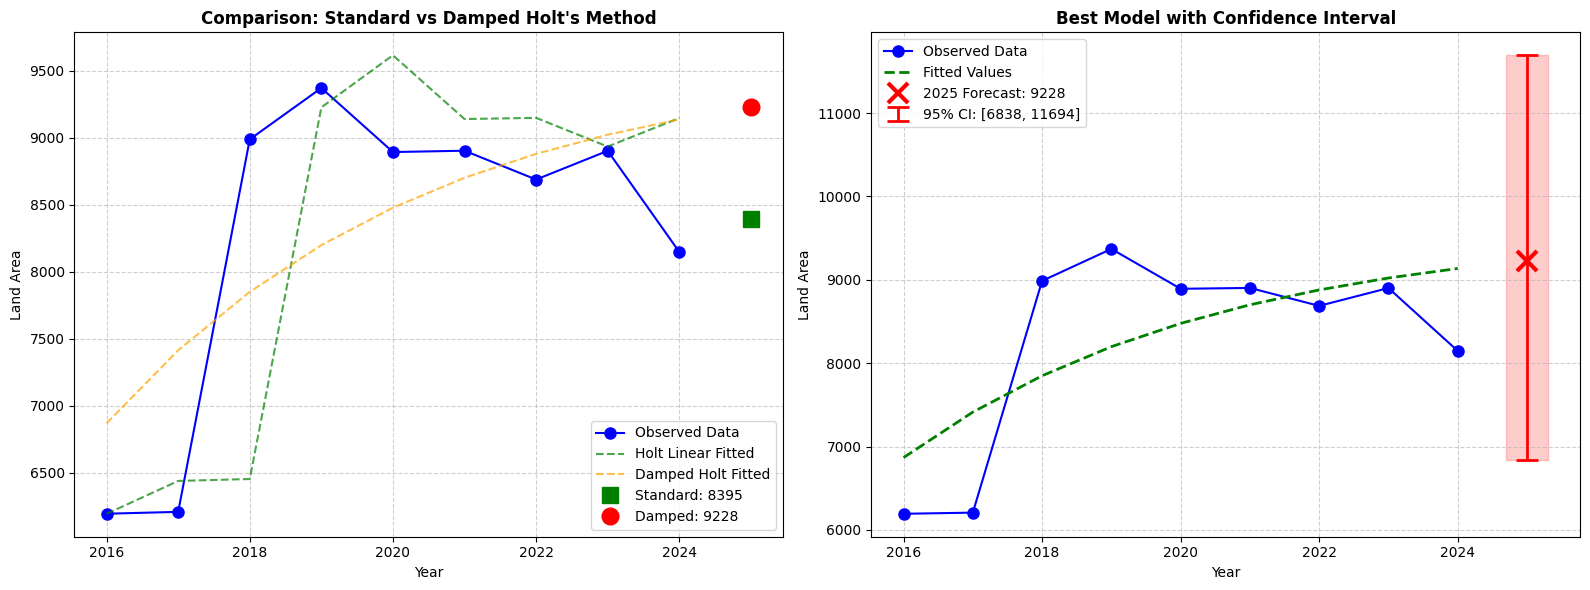

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# 1. Your Data
data = np.array([6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148])
years = np.arange(2016, 2025)
next_year = 2025


# 2. Convert to Time Series
# Use simple integer index instead of datetime for stability with small datasets
ts_data = pd.Series(data, index=np.arange(len(data)))

print(f"Time Series Data:\n{ts_data}\n")


# 3. Try both Standard and Damped Holt's Method
# Damped trend often performs better for small datasets and avoids over-forecasting

try:
    # Standard Holt's Linear Trend
    holt_model = Holt(ts_data, initialization_method="estimated").fit(optimized=True)

    # Damped Holt's Method (recommended for small datasets)
    holt_damped = Holt(ts_data, damped_trend=True, initialization_method="estimated").fit(optimized=True)

    # Extract parameters
    alpha = holt_model.params['smoothing_level']
    beta = holt_model.params['smoothing_trend']

    alpha_d = holt_damped.params['smoothing_level']
    beta_d = holt_damped.params['smoothing_trend']
    phi = holt_damped.params['damping_trend']

    # 4. Generate Forecasts
    forecast_steps = 1
    forecast_standard = holt_model.forecast(forecast_steps)
    forecast_damped = holt_damped.forecast(forecast_steps)

    # 5. Calculate Confidence Intervals using Simulation
    # This is the key optimization - adding uncertainty estimates
    n_simulations = 1000

    # Simulate future paths for damped model (recommended)
    simulated_forecasts = holt_damped.simulate(
        nsimulations=forecast_steps,
        repetitions=n_simulations,
        anchor='end'
    )

    # Calculate 95% confidence interval
    lower_ci = simulated_forecasts.quantile(q=0.025, axis='columns').iloc[0]
    upper_ci = simulated_forecasts.quantile(q=0.975, axis='columns').iloc[0]
    pred_std = simulated_forecasts.std(axis='columns').iloc[0]

    # 6. Compare Model Performance (AIC - lower is better)
    aic_standard = holt_model.aic
    aic_damped = holt_damped.aic

    print("="*70)
    print("STANDARD HOLT'S LINEAR TREND")
    print("="*70)
    print(f"Alpha (Level): {alpha:.4f}")
    print(f"Beta (Trend): {beta:.4f}")
    print(f"AIC: {aic_standard:.2f}")
    print(f"Predicted value for {next_year}: {forecast_standard.iloc[0]:.2f}")

    print("\n" + "="*70)
    print("DAMPED HOLT'S METHOD (RECOMMENDED)")
    print("="*70)
    print(f"Alpha (Level): {alpha_d:.4f}")
    print(f"Beta (Trend): {beta_d:.4f}")
    print(f"Phi (Damping): {phi:.4f}")
    print(f"AIC: {aic_damped:.2f}")
    print(f"Predicted value for {next_year}: {forecast_damped.iloc[0]:.2f}")
    print(f"Standard Deviation: {pred_std:.2f}")
    print(f"95% Confidence Interval: [{lower_ci:.2f}, {upper_ci:.2f}]")
    print("="*70)

    # Select the best model based on AIC
    if aic_damped < aic_standard:
        print(f"\n✓ Damped Holt's method is better (lower AIC by {aic_standard - aic_damped:.2f})")
        best_model = holt_damped
        best_forecast = forecast_damped.iloc[0]
    else:
        print(f"\n✓ Standard Holt's method is better (lower AIC by {aic_damped - aic_standard:.2f})")
        best_model = holt_model
        best_forecast = forecast_standard.iloc[0]

    # 7. Visualize Results with Confidence Intervals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left plot: Comparison of both methods
    ax1.plot(years, data, 'o-', label='Observed Data', color='blue', markersize=8)
    ax1.plot(years, holt_model.fittedvalues, '--', label='Holt Linear Fitted', color='green', alpha=0.7)
    ax1.plot(years, holt_damped.fittedvalues, '--', label='Damped Holt Fitted', color='orange', alpha=0.7)
    ax1.plot(next_year, forecast_standard.iloc[0], 'gs', ms=12,
             label=f'Standard: {forecast_standard.iloc[0]:.0f}')
    ax1.plot(next_year, forecast_damped.iloc[0], 'ro', ms=12,
             label=f'Damped: {forecast_damped.iloc[0]:.0f}')
    ax1.set_title("Comparison: Standard vs Damped Holt's Method", fontsize=12, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Land Area')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Right plot: Best model with confidence intervals
    ax2.plot(years, data, 'o-', label='Observed Data', color='blue', markersize=8)
    ax2.plot(years, best_model.fittedvalues, '--', label='Fitted Values', color='green', linewidth=2)

    # Plot forecast with confidence interval
    ax2.plot(next_year, best_forecast, 'rx', ms=15, mew=3,
             label=f'2025 Forecast: {best_forecast:.0f}')
    ax2.errorbar(next_year, best_forecast,
                 yerr=[[best_forecast - lower_ci], [upper_ci - best_forecast]],
                 fmt='none', ecolor='red', elinewidth=2, capsize=8, capthick=2,
                 label=f'95% CI: [{lower_ci:.0f}, {upper_ci:.0f}]')

    # Shade confidence region
    ax2.fill_between([next_year - 0.3, next_year + 0.3],
                      [lower_ci, lower_ci], [upper_ci, upper_ci],
                      color='red', alpha=0.2)

    ax2.set_title("Best Model with Confidence Interval", fontsize=12, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Land Area')
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Try using simpler initial values or different optimization settings.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Your Data
data = np.array([6194, 6208, 8988, 9371, 8893, 8903, 8688, 8902, 8148])
years = np.arange(2016, 2025)
next_year = 2025

# 2. Convert to Time Series
# Use simple integer index instead of datetime for stability with small datasets
ts_data = pd.Series(data, index=np.arange(len(data)))

print(f"Time Series Data:\n{ts_data}\n")

# 3. Try both Standard and Damped Holt's Method
# Damped trend often performs better for small datasets and avoids over-forecasting

try:
    # Standard Holt's Linear Trend
    holt_model = Holt(ts_data, initialization_method="estimated").fit(optimized=True)
    
    # Damped Holt's Method (recommended for small datasets)
    holt_damped = Holt(ts_data, damped_trend=True, initialization_method="estimated").fit(optimized=True)
    
    # Extract parameters
    alpha = holt_model.params['smoothing_level']
    beta = holt_model.params['smoothing_trend']
    
    alpha_d = holt_damped.params['smoothing_level']
    beta_d = holt_damped.params['smoothing_trend']
    phi = holt_damped.params['damping_trend']
    
    # 4. Generate Forecasts
    forecast_steps = 1
    forecast_standard = holt_model.forecast(forecast_steps)
    forecast_damped = holt_damped.forecast(forecast_steps)
    
    # 5. Calculate Confidence Intervals using Simulation
    # This is the key optimization - adding uncertainty estimates
    n_simulations = 1000
    
    # Simulate future paths for damped model (recommended)
    simulated_forecasts = holt_damped.simulate(
        nsimulations=forecast_steps,
        repetitions=n_simulations,
        anchor='end'
    )
    
    # Calculate 95% confidence interval
    lower_ci = simulated_forecasts.quantile(q=0.025, axis='columns').iloc[0]
    upper_ci = simulated_forecasts.quantile(q=0.975, axis='columns').iloc[0]
    pred_std = simulated_forecasts.std(axis='columns').iloc[0]
    
    # 6. Compare Model Performance (AIC - lower is better)
    aic_standard = holt_model.aic
    aic_damped = holt_damped.aic
    
    print("="*70)
    print("STANDARD HOLT'S LINEAR TREND")
    print("="*70)
    print(f"Alpha (Level): {alpha:.4f}")
    print(f"Beta (Trend): {beta:.4f}")
    print(f"AIC: {aic_standard:.2f}")
    print(f"Predicted value for {next_year}: {forecast_standard.iloc[0]:.2f}")
    
    print("\n" + "="*70)
    print("DAMPED HOLT'S METHOD (RECOMMENDED)")
    print("="*70)
    print(f"Alpha (Level): {alpha_d:.4f}")
    print(f"Beta (Trend): {beta_d:.4f}")
    print(f"Phi (Damping): {phi:.4f}")
    print(f"AIC: {aic_damped:.2f}")
    print(f"Predicted value for {next_year}: {forecast_damped.iloc[0]:.2f}")
    print(f"Standard Deviation: {pred_std:.2f}")
    print(f"95% Confidence Interval: [{lower_ci:.2f}, {upper_ci:.2f}]")
    print("="*70)
    
    # Select the best model based on AIC
    if aic_damped < aic_standard:
        print(f"\n✓ Damped Holt's method is better (lower AIC by {aic_standard - aic_damped:.2f})")
        best_model = holt_damped
        best_forecast = forecast_damped.iloc[0]
    else:
        print(f"\n✓ Standard Holt's method is better (lower AIC by {aic_damped - aic_standard:.2f})")
        best_model = holt_model
        best_forecast = forecast_standard.iloc[0]
    
    # 7. Visualize Results with Confidence Intervals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Comparison of both methods
    ax1.plot(years, data, 'o-', label='Observed Data', color='blue', markersize=8)
    ax1.plot(years, holt_model.fittedvalues, '--', label='Holt Linear Fitted', color='green', alpha=0.7)
    ax1.plot(years, holt_damped.fittedvalues, '--', label='Damped Holt Fitted', color='orange', alpha=0.7)
    ax1.plot(next_year, forecast_standard.iloc[0], 'gs', ms=12, 
             label=f'Standard: {forecast_standard.iloc[0]:.0f}')
    ax1.plot(next_year, forecast_damped.iloc[0], 'ro', ms=12, 
             label=f'Damped: {forecast_damped.iloc[0]:.0f}')
    ax1.set_title("Comparison: Standard vs Damped Holt's Method", fontsize=12, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Land Area')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Right plot: Best model with confidence intervals
    ax2.plot(years, data, 'o-', label='Observed Data', color='blue', markersize=8)
    ax2.plot(years, best_model.fittedvalues, '--', label='Fitted Values', color='green', linewidth=2)
    
    # Plot forecast with confidence interval
    ax2.plot(next_year, best_forecast, 'rx', ms=15, mew=3, 
             label=f'2025 Forecast: {best_forecast:.0f}')
    ax2.errorbar(next_year, best_forecast, 
                 yerr=[[best_forecast - lower_ci], [upper_ci - best_forecast]], 
                 fmt='none', ecolor='red', elinewidth=2, capsize=8, capthick=2,
                 label=f'95% CI: [{lower_ci:.0f}, {upper_ci:.0f}]')
    
    # Shade confidence region
    ax2.fill_between([next_year - 0.3, next_year + 0.3], 
                      [lower_ci, lower_ci], [upper_ci, upper_ci],
                      color='red', alpha=0.2)
    
    ax2.set_title("Best Model with Confidence Interval", fontsize=12, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Land Area')
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Try using simpler initial values or different optimization settings.")


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path

# Define folder
csv_folder = 'aus_local'  # Adjust to your folder path
csv_files = sorted(glob.glob(os.path.join(csv_folder, '*.csv')))

print(f"Found {len(csv_files)} CSV files\n")

# Function to detect encoding
def detect_encoding(filepath):
    """Try different encodings to read the file"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1', 'windows-1252']
    
    for encoding in encodings:
        try:
            pd.read_csv(filepath, nrows=1, encoding=encoding)
            return encoding
        except:
            continue
    return 'utf-8'  # Default fallback

# Function to preprocess each CSV
def preprocess_csv(filepath):
    """
    Reads CSV with appropriate encoding and handles multi-level headers
    """
    # Detect encoding
    encoding = detect_encoding(filepath)
    print(f"  Encoding: {encoding}")
    
    try:
        # Try reading with multi-level headers
        df = pd.read_csv(filepath, header=[0, 1, 2], encoding=encoding)
    except:
        try:
            # Try with 2-level headers
            df = pd.read_csv(filepath, header=[0, 1], encoding=encoding)
        except:
            # Fall back to single header
            df = pd.read_csv(filepath, encoding=encoding)
    
    return df

# Read all CSVs with error handling
all_data = {}

for csv_file in csv_files:
    filename = os.path.basename(csv_file)
    print(f"Processing: {filename}")
    
    try:
        df = preprocess_csv(csv_file)
        all_data[filename] = df
        print(f"  ✓ Shape: {df.shape}")
        print(f"  ✓ First column: {df.columns[0]}")
        
    except UnicodeDecodeError as e:
        print(f"  ✗ Encoding error: {e}")
        print(f"    Skipping this file")
    except Exception as e:
        print(f"  ✗ Error: {e}")
        print(f"    Skipping this file")
    
    print()

print(f"\nSuccessfully loaded {len(all_data)} files")

# Function to extract district, year, and metric data
def extract_timeseries_data(df):
    """
    Extract district/division, years, and metrics from various CSV formats
    """
    timeseries_data = []
    
    # Flatten multi-level columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip('_').strip() for col in df.columns.values]
    
    # Get the first column (district/division names)
    first_col = df.iloc[:, 0]
    
    # Extract year-metric columns
    for col_idx, col_name in enumerate(df.columns[1:], start=1):
        col_str = str(col_name).lower()
        
        # Look for year patterns (e.g., 2018-19, 2016-17)
        if '-' in col_str and any(digit in col_str for digit in '0123456789'):
            
            # Iterate through rows
            for row_idx, row in df.iterrows():
                district = str(first_col.iloc[row_idx]).strip()
                value = row.iloc[col_idx]
                
                # Skip invalid districts and values
                if district and district.lower() not in ['district', 'division', 'zila', 'unnamed'] and pd.notna(value):
                    try:
                        value = float(value)
                        timeseries_data.append({
                            'District': district,
                            'Column': col_name,
                            'Value': value
                        })
                    except:
                        pass
    
    return pd.DataFrame(timeseries_data)

# Extract and combine all timeseries data
all_timeseries = []

for filename, df in all_data.items():
    print(f"Extracting from: {filename}")
    ts_data = extract_timeseries_data(df)
    print(f"  Extracted {len(ts_data)} records\n")
    all_timeseries.append(ts_data)

# Combine all timeseries data
if all_timeseries:
    combined_ts = pd.concat(all_timeseries, ignore_index=True)
    print(f"Combined timeseries records: {len(combined_ts)}")
    
    # Save preprocessed data
    combined_ts.to_csv('preprocessed_aus_timeseries.csv', index=False)
    print("\n✓ Saved: preprocessed_aus_timeseries.csv")
    
    # Show sample data
    print("\nSample data:")
    print(combined_ts.head(15))
    
    # Get unique districts
    districts = combined_ts['District'].unique()
    print(f"\nUnique districts: {len(districts)}")
    print(districts[:10])
    
    # Function to extract specific metric for Damped Holt's
    def get_district_metric_timeseries(combined_ts, district_name):
        """
        Extract time series for a specific district
        Returns: (years, values) as numpy arrays
        """
        district_data = combined_ts[combined_ts['District'] == district_name].copy()
        district_data = district_data.sort_values('Column')
        
        return district_data['Column'].values, district_data['Value'].values
    
    # Example: Extract data for first district
    first_district = districts[0]
    print(f"\n{'='*70}")
    print(f"EXAMPLE: {first_district}")
    print(f"{'='*70}")
    
    years, values = get_district_metric_timeseries(combined_ts, first_district)
    print(f"Years: {years}")
    print(f"Values: {values}")
    print(f"Data points: {len(values)}")
    
    # Save extraction function to use later
    print("\n✓ Data preprocessing complete!")
    print("Ready for Damped Holt's model")

else:
    print("No data was extracted. Check your CSV files and formats.")


In [ ]:
import sqlite3

In [ ]:
# Create a cursor object
conn = sqlite3.connect("attempt.db")
cursor = conn.cursor()

# Run a query (e.g., list all tables)
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

# Run a query to read all rows from a specific table (replace 'your_table' with a real table name)
cursor.execute("SELECT * FROM yield_summary;")
rows = cursor.fetchall()
for row in rows:
    print(row)

# Close the connection when done
conn.close()


In [1]:
import pandas as pd
import sqlite3

db_file = 'attempt.db'
conn = sqlite3.connect(db_file)

# READ CROP NAMES FROM FILE
crops_file = 'crops.txt'
try:
    with open(crops_file, 'r') as f:
        crop_names = [line.strip() for line in f.readlines() if line.strip()]
    print(f"✓ Loaded {len(crop_names)} crops from {crops_file}\n")
except FileNotFoundError:
    print(f"✗ Error: {crops_file} not found!")
    print("Please create a crops.txt file with crop names (one per line)")
    conn.close()
    exit()
except Exception as e:
    print(f"✗ Error reading {crops_file}: {e}")
    conn.close()
    exit()

print(f"Sample crops: {crop_names[:5]}\n")
print(f"Processing {len(crop_names)} crops\n")

# Function to validate table header format
def validate_table_header(df):
    """Validate table header format"""
    try:
        first_data_val = str(df.iloc[3, 0]).strip()
        if not first_data_val.isdigit():
            return False
    except:
        return False
    
    has_year_col = False
    for col_name in df.columns:
        col_str = str(col_name).strip()
        if '-' in col_str and any(c.isdigit() for c in col_str):
            has_year_col = True
            break
    
    return has_year_col


# Process each crop
skipped_crops = []
processed_crops = 0

for crop in crop_names:
    print(f"Processing: {crop}")
    
    try:
        # Get table names for this crop
        cursor = conn.cursor()
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%{crop}%';")
        table_names = [row[0] for row in cursor.fetchall()]
        
        # CHECK 1: No tables found
        if len(table_names) == 0:
            print(f"  ✗ No tables found for {crop}")
            skipped_crops.append((crop, "No tables found"))
            continue
        
        print(f"  Found {len(table_names)} table(s)")
        
        results = []
        valid_tables = 0
        
        for table_name in table_names:
            try:
                df = pd.read_sql_query(f"SELECT * FROM '{table_name}'", conn)
                
                # CHECK 2: Table is empty
                if len(df) == 0:
                    print(f"    ✗ Table {table_name} is empty - SKIPPING")
                    continue
                
                # CHECK 3: Validate header format
                if not validate_table_header(df):
                    print(f"    ✗ Table {table_name} has invalid header format - SKIPPING")
                    continue
                
                valid_tables += 1
                print(f"    ✓ Table {table_name} is valid")
                
                # Extract data...
                table_year = table_name.split('_')[-1]
                
                for idx in range(3, len(df)):
                    row = df.iloc[idx]
                    try:
                        dist_name = str(row.iloc[1]).strip()
                        
                        if not dist_name or dist_name.lower() in ['none', 'nan', 'unnamed']:
                            continue
                        
                        col_idx = 2
                        year_offset = 0
                        
                        while col_idx + 4 < len(row):
                            try:
                                hectares = float(row.iloc[col_idx + 1])
                                production = float(row.iloc[col_idx + 4])
                                
                                year_base = int(table_year) - 2
                                current_year = year_base + year_offset
                                year_str = f"{current_year}-{str(current_year+1)[-2:]}"
                                
                                if pd.notna(hectares) and pd.notna(production):
                                    results.append({
                                        'District': dist_name,
                                        'Year': year_str,
                                        'Hectares': hectares,
                                        'Production_MT': production
                                    })
                                
                                col_idx += 5
                                year_offset += 1
                            except (ValueError, IndexError):
                                break
                    
                    except Exception as e:
                        pass
            
            except Exception as e:
                print(f"    ✗ Error reading table {table_name}: {e}")
                continue
        
        # CHECK 4: No valid tables processed
        if valid_tables == 0:
            print(f"  ✗ No valid tables found for {crop}")
            skipped_crops.append((crop, "No valid tables after validation"))
            continue
        
        # CHECK 5: No data extracted
        if len(results) == 0:
            print(f"  ✗ No data extracted for {crop}")
            skipped_crops.append((crop, "No data extracted"))
            continue
        
        # Save successful crop
        result_df = pd.DataFrame(results)
        output_file = f'{crop}.csv'
        result_df.to_csv(output_file, index=False)
        print(f"  ✓ SUCCESS: Saved {output_file} ({len(result_df)} records from {valid_tables} table(s))")
        processed_crops += 1
    
    except Exception as e:
        print(f"  ✗ FATAL ERROR for {crop}: {e}")
        skipped_crops.append((crop, f"Fatal error: {str(e)}"))

conn.close()

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"✓ Processed: {processed_crops} crops")
print(f"✗ Skipped: {len(skipped_crops)} crops")

if skipped_crops:
    print(f"\nSkipped crops:")
    for crop, reason in skipped_crops:
        print(f"  - {crop}: {reason}")

print(f"\n✓ Processing complete!")


✓ Loaded 184 crops from crops.txt

Sample crops: ['aman_bona', 'aman_hyv', 'aman_ropa', 'aman_total_dist', 'amaranth_danta']

Processing 184 crops

Processing: aman_bona
  Found 4 table(s)
    ✓ Table aman_bona_dist_2018 is valid
    ✓ Table aman_bona_dist_2020 is valid
    ✓ Table aman_bona_dist_2022 is valid
    ✓ Table aman_bona_dist_2024 is valid
  ✓ SUCCESS: Saved aman_bona.csv (549 records from 4 table(s))
Processing: aman_hyv
  Found 4 table(s)
    ✓ Table aman_hyv_dist_2018 is valid
    ✓ Table aman_hyv_dist_2020 is valid
    ✓ Table aman_hyv_dist_2022 is valid
    ✓ Table aman_hyv(ufshi)_dist_2024 is valid
  ✓ SUCCESS: Saved aman_hyv.csv (546 records from 4 table(s))
Processing: aman_ropa
  Found 4 table(s)
    ✓ Table aman_ropa_dist_2018 is valid
    ✓ Table aman_ropa_dist_2020 is valid
    ✓ Table aman_ropa_dist_2022 is valid
    ✓ Table aman_ropa_dist_2024 is valid
  ✓ SUCCESS: Saved aman_ropa.csv (549 records from 4 table(s))
Processing: aman_total_dist
  Found 4 table(s)


In [2]:
import pandas as pd
import sqlite3

db_file = 'attempt.db'
conn = sqlite3.connect(db_file)

# READ CROP NAMES FROM FILE
crops_file = 'crops.txt'
try:
    with open(crops_file, 'r') as f:
        crop_names = [line.strip() for line in f.readlines() if line.strip()]
    print(f"✓ Loaded {len(crop_names)} crops from {crops_file}\n")
except FileNotFoundError:
    print(f"✗ Error: {crops_file} not found!")
    print("Please create a crops.txt file with crop names (one per line)")
    conn.close()
    exit()
except Exception as e:
    print(f"✗ Error reading {crops_file}: {e}")
    conn.close()
    exit()

print(f"Sample crops: {crop_names[:5]}\n")
print(f"Processing {len(crop_names)} crops\n")

# Function to validate table header format - ONLY ACCEPT SPECIFIC STYLE
def validate_table_header(df):
    """
    Validate table header format - ONLY ACCEPT:
    Row 0: Year columns (e.g., 2015-16, 2016-17, etc.)
    Row 1+: Data starting with numeric ID in first column
    
    Expected format:
    |ID|District|2015-16|2016-17|...|2015-16|2016-17|... (repeated for different metrics)
    1.0|Barguna|214|222|...|858|818|...
    """
    try:
        # CHECK 1: First column of row 0 should be empty or a pipe symbol (not a year)
        first_col_header = str(df.iloc[0, 0]).strip()
        
        # CHECK 2: Row 1 should have numeric ID in first column
        first_data_val = str(df.iloc[1, 0]).strip()
        try:
            float(first_data_val)  # Try to convert to float
        except:
            return False
        
        # CHECK 3: Row 1 second column should be district name (text, not a number)
        second_col_data = str(df.iloc[1, 1]).strip()
        if second_col_data.replace('.', '').isdigit():  # If it's all numbers, it's not a district
            return False
        
        # CHECK 4: Row 0 should have year columns (at least 3 columns with year format YYYY-YY)
        year_col_count = 0
        for col_idx in range(2, len(df.columns)):  # Start from column 2 (skip ID and district)
            col_header = str(df.iloc[0, col_idx]).strip()
            # Check if it matches year format (e.g., 2015-16, 2016-17)
            if '-' in col_header and len(col_header) == 7 and col_header[:4].isdigit():
                year_col_count += 1
        
        # Must have at least 3 year columns
        if year_col_count < 3:
            return False
        
        return True
    
    except Exception as e:
        return False

# Process each crop
skipped_crops = []
processed_crops = 0

for crop in crop_names:
    print(f"Processing: {crop}")
    
    try:
        # Get table names for this crop
        cursor = conn.cursor()
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%{crop}%';")
        table_names = [row[0] for row in cursor.fetchall()]
        
        # CHECK 1: No tables found
        if len(table_names) == 0:
            print(f"  ✗ No tables found for {crop}")
            skipped_crops.append((crop, "No tables found"))
            continue
        
        print(f"  Found {len(table_names)} table(s)")
        
        results = []
        valid_tables = 0
        
        for table_name in table_names:
            try:
                df = pd.read_sql_query(f"SELECT * FROM '{table_name}'", conn)
                
                # CHECK 2: Table is empty
                if len(df) == 0:
                    print(f"    ✗ Table {table_name} is empty - SKIPPING")
                    continue
                
                # CHECK 3: Validate header format (ONLY ACCEPT SPECIFIC STYLE)
                if not validate_table_header(df):
                    print(f"    ✗ Table {table_name} has invalid header format - SKIPPING")
                    continue
                
                valid_tables += 1
                print(f"    ✓ Table {table_name} is valid")
                
                # Extract data...
                table_year = table_name.split('_')[-1]
                
                # Data starts from row 1 (row 0 is header with years)
                for idx in range(1, len(df)):
                    row = df.iloc[idx]
                    try:
                        dist_name = str(row.iloc[1]).strip()
                        
                        if not dist_name or dist_name.lower() in ['none', 'nan', 'unnamed']:
                            continue
                        
                        col_idx = 2
                        year_offset = 0
                        
                        while col_idx + 4 < len(row):
                            try:
                                hectares = float(row.iloc[col_idx + 1])
                                production = float(row.iloc[col_idx + 4])
                                
                                year_base = int(table_year) - 2
                                current_year = year_base + year_offset
                                year_str = f"{current_year}-{str(current_year+1)[-2:]}"
                                
                                if pd.notna(hectares) and pd.notna(production):
                                    results.append({
                                        'District': dist_name,
                                        'Year': year_str,
                                        'Hectares': hectares,
                                        'Production_MT': production
                                    })
                                
                                col_idx += 5
                                year_offset += 1
                            except (ValueError, IndexError):
                                break
                    
                    except Exception as e:
                        pass
            
            except Exception as e:
                print(f"    ✗ Error reading table {table_name}: {e}")
                continue
        
        # CHECK 4: No valid tables processed
        if valid_tables == 0:
            print(f"  ✗ No valid tables found for {crop}")
            skipped_crops.append((crop, "No valid tables after validation"))
            continue
        
        # CHECK 5: No data extracted
        if len(results) == 0:
            print(f"  ✗ No data extracted for {crop}")
            skipped_crops.append((crop, "No data extracted"))
            continue
        
        # Save successful crop
        result_df = pd.DataFrame(results)
        output_file = f'{crop}.csv'
        result_df.to_csv(output_file, index=False)
        print(f"  ✓ SUCCESS: Saved {output_file} ({len(result_df)} records from {valid_tables} table(s))")
        processed_crops += 1
    
    except Exception as e:
        print(f"  ✗ FATAL ERROR for {crop}: {e}")
        skipped_crops.append((crop, f"Fatal error: {str(e)}"))

conn.close()

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"✓ Processed: {processed_crops} crops")
print(f"✗ Skipped: {len(skipped_crops)} crops")

if skipped_crops:
    print(f"\nSkipped crops:")
    for crop, reason in skipped_crops:
        print(f"  - {crop}: {reason}")

print(f"\n✓ Processing complete!")


✓ Loaded 184 crops from crops.txt

Sample crops: ['aman_bona', 'aman_hyv', 'aman_ropa', 'aman_total_dist', 'amaranth_danta']

Processing 184 crops

Processing: aman_bona
  Found 4 table(s)
    ✗ Table aman_bona_dist_2018 has invalid header format - SKIPPING
    ✗ Table aman_bona_dist_2020 has invalid header format - SKIPPING
    ✗ Table aman_bona_dist_2022 has invalid header format - SKIPPING
    ✗ Table aman_bona_dist_2024 has invalid header format - SKIPPING
  ✗ No valid tables found for aman_bona
Processing: aman_hyv
  Found 4 table(s)
    ✗ Table aman_hyv_dist_2018 has invalid header format - SKIPPING
    ✗ Table aman_hyv_dist_2020 has invalid header format - SKIPPING
    ✗ Table aman_hyv_dist_2022 has invalid header format - SKIPPING
    ✗ Table aman_hyv(ufshi)_dist_2024 has invalid header format - SKIPPING
  ✗ No valid tables found for aman_hyv
Processing: aman_ropa
  Found 4 table(s)
    ✗ Table aman_ropa_dist_2018 has invalid header format - SKIPPING
    ✗ Table aman_ropa_dist_

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt
import os
import warnings

warnings.filterwarnings('ignore')

# Get all CSV files from crops folder
crops_folder = 'crops'
csv_files = [f for f in os.listdir(crops_folder) if f.endswith('.csv')]

print(f"Found {len(csv_files)} crop CSV files\n")

# Process each crop
for csv_file in csv_files:
    crop_name = csv_file.replace('.csv', '')
    print(f"Processing: {crop_name}")
    
    try:
        # Read the crop data from crops folder
        df = pd.read_csv(os.path.join(crops_folder, csv_file))
        
        # Check if data exists
        if len(df) == 0:
            print(f"  ✗ No data in {csv_file}")
            continue
        
        # Get unique districts
        districts = df['District'].unique()
        print(f"  Found {len(districts)} districts")
        
        predictions = []
        
        # Process each district
        for district in districts:
            district_data = df[df['District'] == district].sort_values('Year')
            
            if len(district_data) < 2:
                print(f"    ✗ {district}: Insufficient data (less than 2 years)")
                continue
            
            try:
                # Extract data for area and production
                hectares = district_data['Hectares'].values
                production = district_data['Production_MT'].values
                
                # Skip if all zeros
                if np.sum(hectares) == 0 and np.sum(production) == 0:
                    print(f"    ✗ {district}: All zeros - SKIPPING")
                    continue
                
                # Skip if contains NaN or inf
                if np.any(np.isnan(hectares)) or np.any(np.isinf(hectares)) or \
                   np.any(np.isnan(production)) or np.any(np.isinf(production)):
                    print(f"    ✗ {district}: Contains NaN or inf - SKIPPING")
                    continue
                
                # Convert to pandas Series for Holt's method
                ts_hectares = pd.Series(hectares, index=np.arange(len(hectares)))
                ts_production = pd.Series(production, index=np.arange(len(production)))
                
                # Apply Damped Holt's method for Hectares
                holt_hectares = Holt(ts_hectares, damped_trend=True, initialization_method="estimated").fit(optimized=True)
                hectares_pred = holt_hectares.forecast(1).iloc[0]
                
                # Apply Damped Holt's method for Production
                holt_production = Holt(ts_production, damped_trend=True, initialization_method="estimated").fit(optimized=True)
                production_pred = holt_production.forecast(1).iloc[0]
                
                # Ensure predictions are non-negative
                hectares_pred = max(0, hectares_pred)
                production_pred = max(0, production_pred)
                
                predictions.append({
                    'District': district,
                    'Area_Hectares_Pred': hectares_pred,
                    'Production_MT_Pred': production_pred
                })
                
                print(f"    ✓ {district}: Area={hectares_pred:.2f}, Prod={production_pred:.2f}")
            
            except Exception as e:
                print(f"    ✗ {district}: {e}")
                continue
        
        # Save predictions to current directory
        if predictions:
            pred_df = pd.DataFrame(predictions)
            output_file = f'{crop_name}_predictions.csv'
            pred_df.to_csv(output_file, index=False)
            print(f"  ✓ Saved: {output_file} ({len(predictions)} districts)\n")
        else:
            print(f"  ✗ No predictions generated for {crop_name}\n")
    
    except Exception as e:
        print(f"  ✗ Error processing {csv_file}: {e}\n")

print("✓ Forecasting complete!")


Found 166 crop CSV files

Processing: aman_bona
  Found 88 districts
    ✗ Bhola: All zeros - SKIPPING
    ✗ Jhalakathi: All zeros - SKIPPING
    ✗ Patuakhali: All zeros - SKIPPING
    ✓ Pirojpur: Area=1778.80, Prod=2386.64
    ✓ Barishal
Division: Area=3604.09, Prod=3633.22
    ✗ Bandarban: All zeros - SKIPPING
    ✓ Brahmanbaria: Area=12987.40, Prod=16637.48
    ✓ Chandpur: Area=12222.10, Prod=12196.90
    ✓ Chattogram: Area=3737.09, Prod=4915.18
    ✓ Cumilla: Area=3890.98, Prod=7972.47
    ✗ Cox' Bazar: All zeros - SKIPPING
    ✗ Feni: All zeros - SKIPPING
    ✗ Khagrachari: All zeros - SKIPPING
    ✓ Laksmipur: Area=7566.78, Prod=9836.97
    ✓ Noakhali: Area=0.00, Prod=0.00
    ✗ Rangamati: All zeros - SKIPPING
    ✓ Chattogram
Division: Area=40480.40, Prod=42198.59
    ✓ Dhaka: Area=4117.88, Prod=4095.19
    ✓ Faridpur: Area=9443.99, Prod=11426.60
    ✓ Gazipur: Area=1590.35, Prod=1885.35
    ✓ Gopalgonj: Area=12616.22, Prod=16267.28
    ✗ Kishoregonj: All zeros - SKIPPING
    ✓ 